# Prediction of Euro 2024 Qualifications in Final Phases
This notebook runs simulations of the 2024 Euro cup, taking into account the probabilities that each team has to win each pool match, as well as the "kickscore" of each team (both coming from [kickoff.ai](http://kickoff.ai/)).

As the notebook has been written before the start of the competition, only the teams playing pool matches are known. For latter stages (where adversaries are not yet known), the simulator uses the "kickscore" $s_A$ and $s_B$ of two opposing teams $A$ and $B$, in order to obtain the probability $p$ that the team with the highest kickscore wins: $$p = \frac{1}{1 + e^{-c|s_A - s_B|}},$$
where $c$ is some scaling constant.

This logic should also work with other notions of "team strength"; so you can try plugging your own!

Once the simulations are run, the notebook explores the quality of some predictions. Predictions here means deciding the set of teams that will be in 8th of final, 4th, etc. as well as who will be 1st, 2nd and third. 
One can use the function `points_for_preds()` in order to know the full distribution of points (for a given betting system) that results from a given set of predictions. From the simulation results, it is easy to retrieve the prediction that maximizes the expected number of points. However, there might be other predictions that bring nearly as many points on expectation but are more diverse (e.g., involving more teams in the latter stages). Such predictions reduce risk (while paying only a small price in expected reward) and are more likely to maintain the suspense high until the end for the player!

In [5]:
from collections import defaultdict
from dataclasses import dataclass
from typing import List

from tqdm import tqdm
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pprint
from random import random
matplotlib.rcParams.update({'font.size': 16})

NR_RUNS = 100000

## First, some data
Here we encode the probabilities of each team winning, the level of each team (coming directly from [kickoff.ai](http://kickoff.ai)), as well as the structure of the groups and finals.

In [17]:
# expressed in percentage (team1_win, draw, team2_win)
pools_probas = {
    ('Germany', 'Scotland'): (53, 27, 20),
    ('Hungary', 'Switzerland'): (31, 30, 39),
    ('Spain', 'Croatia'): (48, 29, 23),
    ('Italy', 'Albania'): (80, 15, 5),
    ('Poland', 'Netherlands'): (18, 27, 55),
    ('Slovenia', 'Denmark'): (19, 27, 54),
    ('Serbia', 'England'): (15, 25, 60),
    ('Romania', 'Ukraine'): (23, 29, 48),
    ('Belgium', 'Slovakia'): (71, 20, 9),
    ('Austria', 'France'): (17, 26, 57),
    ('Turkey', 'Georgia'): (52, 27, 21),
    ('Portugal', 'Czech Republic'): (56, 26, 18),
    ('Croatia', 'Albania'): (72, 19, 9),
    ('Germany', 'Hungary'): (49, 29, 22),
    ('Scotland', 'Switzerland'): (28, 29, 43),
    ('Slovenia', 'Serbia'): (25, 29, 46),
    ('Denmark', 'England'): (21, 27, 52),
    ('Spain', 'Italy'): (38, 30, 32),
    ('Slovakia', 'Ukraine'): (21, 28, 51),
    ('Poland', 'Austria'): (30, 30, 40),
    ('Netherlands', 'France'): (28, 30, 42),
    ('Georgia', 'Czech Republic'): (18, 26, 56),
    ('Turkey', 'Portugal'): (15, 25, 60),
    ('Belgium', 'Romania'): (68, 21, 11),
    ('Switzerland', 'Germany'): (26, 29, 45),
    ('Scotland', 'Hungary'): (32, 30, 38),
    ('Croatia', 'Italy'): (26, 30, 44),
    ('Albania', 'Spain'): (4, 14, 82),
    ('Netherlands', 'Austria'): (49, 29, 22),
    ('France', 'Poland'): (62, 24, 14),
    ('England', 'Slovenia'): (70, 20, 10),
    ('Denmark', 'Serbia'): (43, 29, 28),
    ('Slovakia', 'Romania'): (32, 31, 37),
    ('Ukraine', 'Belgium'): (18, 27, 55),
    ('Czech Republic', 'Turkey'): (39, 30, 31),
    ('Georgia', 'Portugal'): (7, 18, 75),
}

kickscores = {
    'Germany': 1.32, 'Scotland': 0.86, 'Hungary': 1.06, 'Switzerland': 0.92,
    'Spain': 1.56, 'Croatia': 1.29, 'Italy': 1.54, 'Albania': 0.18,
    'Poland': 0.89, 'Netherlands': 1.44, 'Slovenia': 0.77, 'Denmark': 1.02,
    'Serbia': 0.94, 'England': 1.6, 'Romania': 0.87, 'Ukraine': 1.04,
    'Belgium': 1.29, 'Slovakia': 0.6, 'France': 1.48, 'Austria': 1.05,
    'Turkey': 0.78, 'Georgia': 0.33, 'Portugal': 1.35, 'Czech Republic': 1.05,
}
    
groups = {
    'A': ['Germany', 'Scotland', 'Hungary', 'Switzerland'],
    'B': ['Spain', 'Croatia', 'Italy', 'Albania'],
    'C': ['Slovenia', 'Denmark', 'Serbia', 'England'],
    'D': ['Poland', 'Netherlands', 'Austria', 'France'],
    'E': ['Belgium', 'Slovakia', 'Romania', 'Ukraine'],
    'F': ['Turkey', 'Georgia', 'Portugal', 'Czech Republic']
}

# who will play against who?
finals_8_orig = {
    '8A': ((2, 'A'), (2, 'B')),  # match 'A' of 8th of finals will be 2nd team of group A -vs- 2nd team of group B
    '8B': ((1, 'A'), (2, 'C')),
    '8C': ((1, 'C'), (3, 'DEF')),  #  match 'C' will be 1st team of group C -vs- 3rd of either D, E or F 
                                   #  (as determined by which 3rd place teams are qualified)
    '8D': ((1, 'B'), (3, 'ADEF')),
    '8E': ((2, 'D'), (2, 'E')),
    '8F': ((1, 'F'), (3, 'ABC')),
    '8G': ((1, 'D'), (2, 'F')),
    '8H': ((1, 'E'), (3, 'ABCD'))
}

#### TODO - confirm this (?)

# set of 4 third-place teams -> who will play which match
third_teams_resolution = {
    ('A', 'B', 'C', 'D'): {'ADEF': 'A', 'DEF': 'D', 'ABCD': 'B', 'ABC': 'C'},
    ('A', 'B', 'C', 'E'): {'ADEF': 'A', 'DEF': 'E', 'ABCD': 'B', 'ABC': 'C'},
    ('A', 'B', 'C', 'F'): {'ADEF': 'A', 'DEF': 'F', 'ABCD': 'B', 'ABC': 'C'},
    ('A', 'B', 'D', 'E'): {'ADEF': 'D', 'DEF': 'E', 'ABCD': 'A', 'ABC': 'B'},
    ('A', 'B', 'D', 'F'): {'ADEF': 'D', 'DEF': 'F', 'ABCD': 'A', 'ABC': 'B'},
    ('A', 'B', 'E', 'F'): {'ADEF': 'E', 'DEF': 'F', 'ABCD': 'B', 'ABC': 'A'},
    ('A', 'C', 'D', 'E'): {'ADEF': 'E', 'DEF': 'D', 'ABCD': 'C', 'ABC': 'A'},
    ('A', 'C', 'D', 'F'): {'ADEF': 'F', 'DEF': 'D', 'ABCD': 'C', 'ABC': 'A'},
    ('A', 'C', 'E', 'F'): {'ADEF': 'E', 'DEF': 'F', 'ABCD': 'C', 'ABC': 'A'},
    ('A', 'D', 'E', 'F'): {'ADEF': 'E', 'DEF': 'F', 'ABCD': 'D', 'ABC': 'A'},
    ('B', 'C', 'D', 'E'): {'ADEF': 'E', 'DEF': 'D', 'ABCD': 'B', 'ABC': 'C'},
    ('B', 'C', 'D', 'F'): {'ADEF': 'F', 'DEF': 'D', 'ABCD': 'C', 'ABC': 'B'},
    ('B', 'C', 'E', 'F'): {'ADEF': 'F', 'DEF': 'E', 'ABCD': 'C', 'ABC': 'B'},
    ('B', 'D', 'E', 'F'): {'ADEF': 'F', 'DEF': 'E', 'ABCD': 'D', 'ABC': 'B'},
    ('C', 'D', 'E', 'F'): {'ADEF': 'F', 'DEF': 'E', 'ABCD': 'D', 'ABC': 'C'}
}

finals_4 = {
    '4A': ('8H', '8G'),
    '4B': ('8F', '8E'),
    '4C': ('8C', '8A'),
    '4D': ('8D', '8B')
}

finals_2 = { '2A': ('4A', '4C'), '2B': ('4D', '4B') }

final = {'1A': ('2A', '2B')}

def get_observed_result(team1, team2, d):
    """ Conveniently query the above maps
        d is the map to query (groups or finals)
        Return None if match has not been observed
    """
    observed_result = None
    if (team1, team2) in d:
        observed_result = d[(team1, team2)]
    elif (team2, team1) in d:
        observed_result = d[(team2, team1)]
    return observed_result

### Taking into account events as they happen
Below, we encode some actual events (pool/final match results, third teams points and group rankings) as they become known during the course of the cup. Our simulator below can take the list `events` in argument in order to condition the probabilities to whatever is already realised.

In [18]:
# A sorted list of events, capturing sequence of things that happened so far
@dataclass
class PoolMatchResult:
    team1: str
    team2: str
    result: str  # 'draw' allowed
        
@dataclass
class FinalMatchResult:
    team1: str
    team2: str
    result: str  # 'draw' not allowed
        
@dataclass
class ObservedThirdTeamPts:
    group: str
    pts: float
        
@dataclass
class ObservedGroupRanking:
    group: str
    ranking: List[str]

events = []

"""
events = [
    [PoolMatchResult('Turkey', 'Italy', 'Italy')],   
    [PoolMatchResult('Wales', 'Switzerland', 'draw')],
    [PoolMatchResult('Denmark', 'Finland', 'Finland')],
    [PoolMatchResult('Belgium', 'Russia', 'Belgium')],
    [PoolMatchResult('England', 'Croatia', 'England')],
    [PoolMatchResult('Austria', 'North Macedonia', 'Austria')],
    [PoolMatchResult('Netherlands', 'Ukraine', 'Netherlands')],
    [PoolMatchResult('Scotland', 'Czech Republic', 'Czech Republic')],
    [PoolMatchResult('Poland', 'Slovakia', 'Slovakia')],
    [PoolMatchResult('Spain', 'Sweden', 'draw')],
    [PoolMatchResult('Hungary', 'Portugal', 'Portugal')],
    [PoolMatchResult('France', 'Germany', 'France')],
    [PoolMatchResult('Finland', 'Russia', 'Russia')],
    [PoolMatchResult('Turkey', 'Wales', 'Wales')],
    [PoolMatchResult('Switzerland', 'Italy', 'Italy')],
    [PoolMatchResult('Ukraine', 'North Macedonia', 'Ukraine')],
    [PoolMatchResult('Denmark', 'Belgium', 'Belgium')],
    [PoolMatchResult('Netherlands', 'Austria', 'Netherlands')],
    [PoolMatchResult('Sweden', 'Slovakia', 'Sweden')],
    [PoolMatchResult('Croatia', 'Czech Republic', 'draw')],
    [PoolMatchResult('England', 'Scotland', 'draw')],
    [PoolMatchResult('Hungary', 'France', 'draw')],
    [PoolMatchResult('Portugal', 'Germany', 'Germany')],
    [PoolMatchResult('Spain', 'Poland', 'draw')],
    [PoolMatchResult('Italy', 'Wales', 'Italy')],
    
    [PoolMatchResult('Switzerland', 'Turkey', 'Switzerland'), ObservedThirdTeamPts('A', 4),
     ObservedGroupRanking('A', ['Italy', 'Wales', 'Switzerland', 'Turkey'])],
    
    [PoolMatchResult('Ukraine', 'Austria', 'Austria'), ObservedThirdTeamPts('C', 3.5)],  # 3.5 is a hack
    
    [PoolMatchResult('North Macedonia', 'Netherlands', 'Netherlands'),
     ObservedGroupRanking('C', ['Netherlands', 'Austria', 'Ukraine', 'North Macedonia'])],
    
    [PoolMatchResult('Russia', 'Denmark', 'Denmark')],
    
    [PoolMatchResult('Finland', 'Belgium', 'Belgium'), ObservedThirdTeamPts('B', 3),
     ObservedGroupRanking('B', ['Belgium', 'Denmark', 'Finland', 'Russia'])],
    
    [PoolMatchResult('Croatia', 'Scotland', 'Croatia')],
    
    [PoolMatchResult('Czech Republic', 'England', 'England'), ObservedThirdTeamPts('D', 4),
     ObservedGroupRanking('D', ['England', 'Croatia', 'Czech Republic', 'Scotland'])],
    
    [PoolMatchResult('Sweden', 'Poland', 'Sweden')],
    
    [PoolMatchResult('Slovakia', 'Spain', 'Spain'), ObservedThirdTeamPts('E', 3),
     ObservedGroupRanking('E', ['Sweden', 'Spain', 'Slovakia', 'Poland'])],
    
    [PoolMatchResult('Portugal', 'France', 'draw'), ObservedThirdTeamPts('F', 4)],
    
    [PoolMatchResult('Germany', 'Hungary', 'draw'), 
     ObservedGroupRanking('F', ['France', 'Germany', 'Portugal', 'Hungary'])],
    
    # 8th
    [FinalMatchResult('Wales', 'Denmark', 'Denmark')],
    [FinalMatchResult('Italy', 'Austria', 'Italy')],
    [FinalMatchResult('Netherlands', 'Czech Republic', 'Czech Republic')],
    [FinalMatchResult('Belgium', 'Portugal', 'Belgium')],
    [FinalMatchResult('Croatia', 'Spain', 'Spain')],
    [FinalMatchResult('France', 'Switzerland', 'Switzerland')],
    [FinalMatchResult('England', 'Germany', 'England')],
    [FinalMatchResult('Sweden', 'Ukraine', 'Ukraine')],
    
    # 4th
    [FinalMatchResult('Switzerland', 'Spain', 'Spain')],
    [FinalMatchResult('Belgium', 'Italy', 'Italy')],
    [FinalMatchResult('Czech Republic', 'Denmark', 'Denmark')],
    [FinalMatchResult('Ukraine', 'England', 'England')],
    
    # semi
    [FinalMatchResult('Italy', 'Spain', 'Italy')],
    [FinalMatchResult('England', 'Denmark', 'England')]
]
"""
pass

## Some functions to randomly draw match winners
Some function to simulate match winners, for both pool matches (where draw is allowed) and final rounds (where there is no draw).

In [19]:
def play_pool_match(team1, team2, observed_results_groups):
    """ Returns a dict containing a map from the team to the score it obtained (draw possible)
    """

    # first, check if match has already been played, in which case return observed result
    obs_winner = get_observed_result(team1, team2, observed_results_groups)
    if obs_winner is not None:
        if obs_winner == 'draw':
            return {team1: 1 + 0.01 * kickscores[team1], team2: 1 + 0.01 * kickscores[team2]}
        else:
            loosing_team = team1 if obs_winner == team2 else team2
            return {obs_winner: 3 + 0.01 * kickscores[obs_winner], loosing_team: 0 + 0.01 * kickscores[loosing_team]}
    
    # Match has not been observed; retrieve correct probabilities from known pool-match probabilities
    if (team1, team2) in pools_probas:
        pr_team1, pr_draw, pr_team2 = pools_probas[(team1, team2)]
    elif (team2, team1) in pools_probas:
        pr_team2, pr_draw, pr_team1 = pools_probas[(team2, team1)]
    else:
        print('Unknown pool match! ({}, {})'.format(team1, team2))
        
    # put them in convenient form for randomly drawing score
    team_probas = sorted([(team1, pr_team1), ('draw', pr_draw), (team2, pr_team2)], key=lambda t: -t[1])
        
    # decide result
    prn = 100 * random()
    for team, pr in team_probas:
        if prn <= pr:
            # "team" won
            if team == 'draw':
                # add a small salt proportional to kickscore, to later break ties
                # note, this is not really ideal; we should randomly draw tie using logistic function instead
                return {team1: 1 + 0.01 * kickscores[team1], team2: 1 + 0.01 * kickscores[team2]}
            else:
                loosing_team = team1 if team == team2 else team2
                return {team: 3 + 0.01 * kickscores[team], loosing_team: 0 + 0.01 * kickscores[loosing_team]}
        else:
            prn -= pr
            
def logistic_fun(x):
    """ x is a kickscore difference
    """
    s = 1.5  # a scale parameter, more or less manually fitted/guessed
    return 1. / (1. + math.exp(-x * s))

def play_match(team1, team2, observed_results_finals):
    """ Returns the winner (no draw)
    """    
    # First, check whether the match has already been observed
    observed_winner = get_observed_result(team1, team2, observed_results_finals)
    if observed_winner is not None:
        return observed_winner
    
    # The match has not been played; simulate outcome
    kickscore_1 = kickscores[team1]
    kickscore_2 = kickscores[team2]
    is_1_fav = kickscore_1 > kickscore_2
    pr = logistic_fun(abs(kickscore_1 - kickscore_2))
    
    prn = random()
    if prn <= pr:
        # The favorite wins
        return team1 if is_1_fav else team2
    return team2 if is_1_fav else team1
            
def play_group(group, observed_results_groups, observed_groups_orderings, observed_third_team_pts):
    """ Returns a list of the group teams, ordered from 1st to 4th
        Also return the number of points obtained by the third team (needed for selecting third-placed teams later on)
    """
    
    # First, check whether we already have an observed ordering for the group:
    if group in observed_groups_orderings:
        return observed_groups_orderings[group], observed_third_team_pts[group]
    
    # We don't have an ordering; simulate it
    group_teams = groups[group]
    already_played = set()
    team_to_pts = defaultdict(int)
    for team1 in group_teams:
        for team2 in group_teams:
            if team1 == team2 or (team1, team2) in already_played:
                continue
                
            # play the match
            scores = play_pool_match(team1, team2, observed_results_groups)
            
            # keep track of sums of scores
            for team, pts in scores.items():
                team_to_pts[team] += pts
            
            already_played.add((team1, team2))
            already_played.add((team2, team1))    
        
    sorted_teams = sorted(list(team_to_pts.items()), key=lambda t: -t[1])
    sorted_teams = list(map(lambda t: t[0], sorted_teams))
    return sorted_teams, team_to_pts[sorted_teams[2]]

""" The following function simulates all matches in a final
"""
def play_final(matchs, prev_winners, counts_to_update, observed_results_finals, is_8th=False):
    """ Returns a map <match_id --> winner>
    """
    
    finals_to_winner = dict()
    
    for match in matchs.keys():
        advs = matchs[match]

        # pick the actual teams who won the pools
        if is_8th:
            # in this case prev_winners values are lists of teams
            team1 = prev_winners[advs[0][1]][advs[0][0] - 1]
            team2 = prev_winners[advs[1][1]][advs[1][0] - 1]
        else:
            team1 = prev_winners[advs[0]]
            team2 = prev_winners[advs[1]]
            
        winner = play_match(team1, team2, observed_results_finals)

        counts_to_update[winner] += 1
        finals_to_winner[match] = winner
        
    return finals_to_winner

## The actual simulation:
Here we simulate the euro for `nr_runs`. For each category, we store the number of times each team falls in this category. In addition, we also store the realisations, so as to be able to obtain points distributions or particular bets later on.

In [26]:
# names of the categories that interest us
categories = ['8th', '4th', 'semi', 'final', 'winner', 'second',]  # 'third']

def create_dicts_from_events(events: List[List]):
    observed_pool_results = dict()
    observed_final_results = dict()
    observed_third_teams_pts = dict()
    observed_group_rankings = dict()
    
    for event_sublist in events:
        for event in event_sublist:
            if isinstance(event, PoolMatchResult):
                observed_pool_results[(event.team1, event.team2)] = event.result
            elif isinstance(event, FinalMatchResult):
                observed_final_results[(event.team1, event.team2)] = event.result
            elif isinstance(event, ObservedThirdTeamPts):
                observed_third_teams_pts[event.group] = event.pts
            elif isinstance(event, ObservedGroupRanking):
                observed_group_rankings[event.group] = event.ranking
                
    return observed_pool_results, observed_final_results, observed_third_teams_pts, observed_group_rankings

def simulate(observed_events, nr_runs):
    # counts number of times we observe each of the teams in each position
    # (category_name --> (team --> count))
    counts = { name: defaultdict(int) for name in categories }

    # keep track of the realisations
    # [(category_name -> set(teams_in_this_category)), ...]
    realisations = []
    
    observations = create_dicts_from_events(observed_events)
    observed_pool_results, observed_final_results, observed_third_teams_pts, observed_group_rankings = observations

    for run in tqdm(range(nr_runs)):
        """ Play the pools
        """
        group_2_teams_sorted = dict()
        group_2_third_teams_points = dict()

        for group in groups.keys():
            teams_sorted, third_team_points = play_group(group, observed_pool_results, 
                                                         observed_group_rankings, observed_third_teams_pts)
            counts['8th'][teams_sorted[0]] += 1
            counts['8th'][teams_sorted[1]] += 1
            group_2_teams_sorted[group] = teams_sorted
            group_2_third_teams_points[group] = third_team_points + 0.01 * random()

        """ Select third-placed teams
        """
        selected_third_teams_groups = tuple(sorted(map(lambda t: t[0], sorted(group_2_third_teams_points.items(), key=lambda t: -t[1])[:4])))
        selected_third_teams = set()
        for group, teams_sorted in group_2_teams_sorted.items():
            if group in selected_third_teams_groups:
                selected_third_teams.add(teams_sorted[2])
                counts['8th'][teams_sorted[2]] += 1

        """ Update finals_8 with the actual third teams that will play the 8-th of finals
        """
        new_keyvals = []
        for k, (t1, t2) in finals_8_orig.items():
            if len(t2[1]) > 1:
                new_keyvals.append((k, (t1, (t2[0], third_teams_resolution[selected_third_teams_groups][t2[1]]))))
        finals_8 = finals_8_orig.copy()
        for k, v in new_keyvals:
            # print('for {}, replacing {} with {}'.format(k, finals_8_orig[k], v))
            finals_8[k] = v

        """ Play the finals
        """
        finals_8_to_winner = play_final(finals_8, group_2_teams_sorted, counts['4th'], 
                                        observed_results_finals=observed_final_results, is_8th=True)
        finals_4_to_winner = play_final(finals_4, finals_8_to_winner, counts['semi'],
                                        observed_results_finals=observed_final_results)
        finals_2_to_winner = play_final(finals_2, finals_4_to_winner, counts['final'],
                                        observed_results_finals=observed_final_results)
        final_to_winner = play_final(final, finals_2_to_winner, counts['winner'],
                                     observed_results_finals=observed_final_results)

        # store score of 2nd
        winner = final_to_winner['1A']
        second = finals_2_to_winner['2A'] if finals_2_to_winner['2A'] != winner else finals_2_to_winner['2B']
        counts['second'][second] += 1

        # play match for 3rd place
        semi_final_winners = set(finals_2_to_winner.values())
        semi_final_loosers = list(set(finals_4_to_winner.values()) - semi_final_winners)
        third = play_match(semi_final_loosers[0], semi_final_loosers[1], observed_results_finals=observed_final_results)
        counts['third'][third] += 1


        """ Store the realisation
        """
        teams_in_8th = selected_third_teams
        for group in groups.keys():
            teams_sorted = group_2_teams_sorted[group]
            teams_in_8th.add(teams_sorted[0])
            teams_in_8th.add(teams_sorted[1])
        real = {
            '8th': teams_in_8th,
            '4th': set(finals_8_to_winner.values()),
            'semi': set(finals_4_to_winner.values()),
            'final': set(finals_2_to_winner.values()),
            'winner': set([winner]),
            'second': set([second]),
            'third': set([third])
        }
        realisations.append(real)
        
    return counts, realisations

### Simulate taking all known `events` into account

In [21]:
counts, realisations = simulate(events, nr_runs=NR_RUNS)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:10<00:00, 9178.82it/s]


## Compute and display the probabilities to fall in each category for each team:
Here, for each category, we compute and display the probability that each team falls in this category (over all simulation runs). Use the Juypter menu Cell --> current outputs --> toggle scrolling to see all plots without scrolling within the cell output.

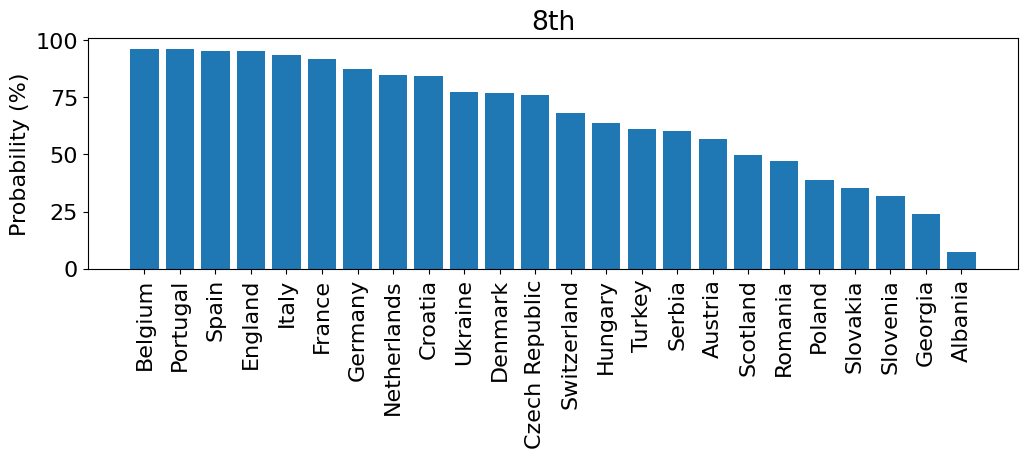

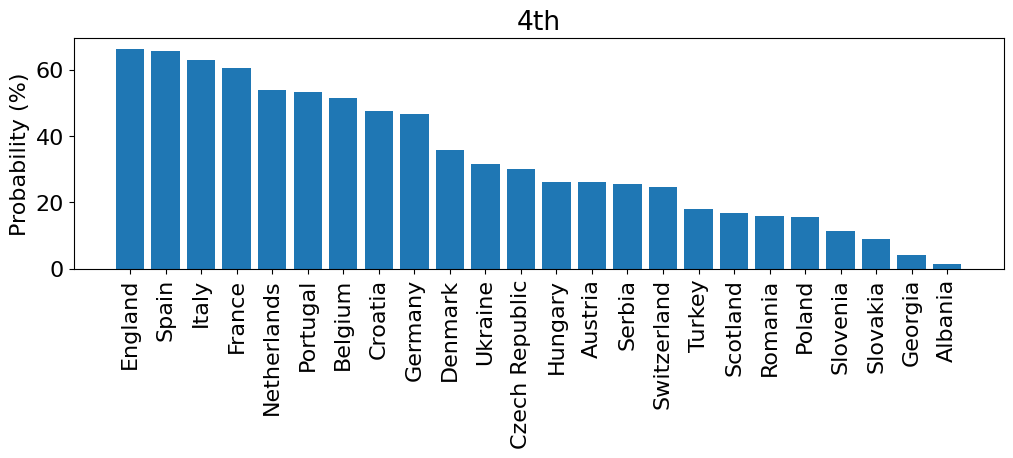

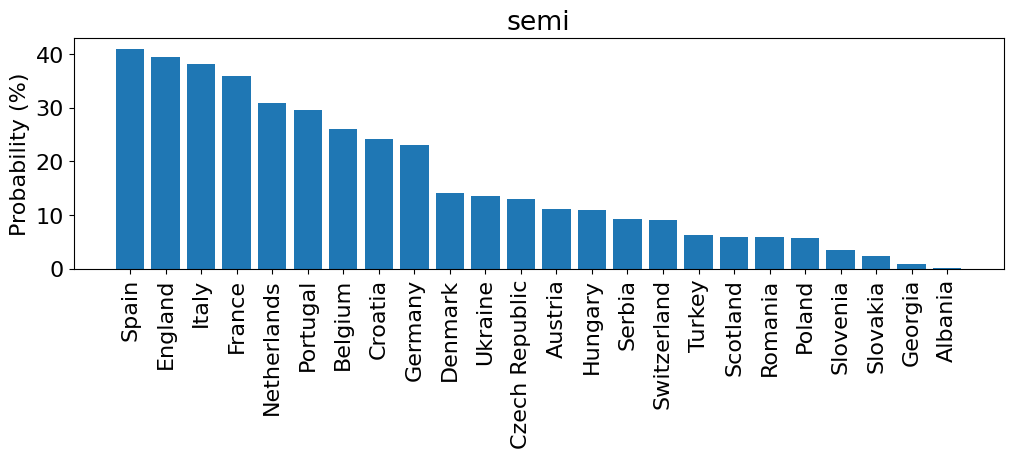

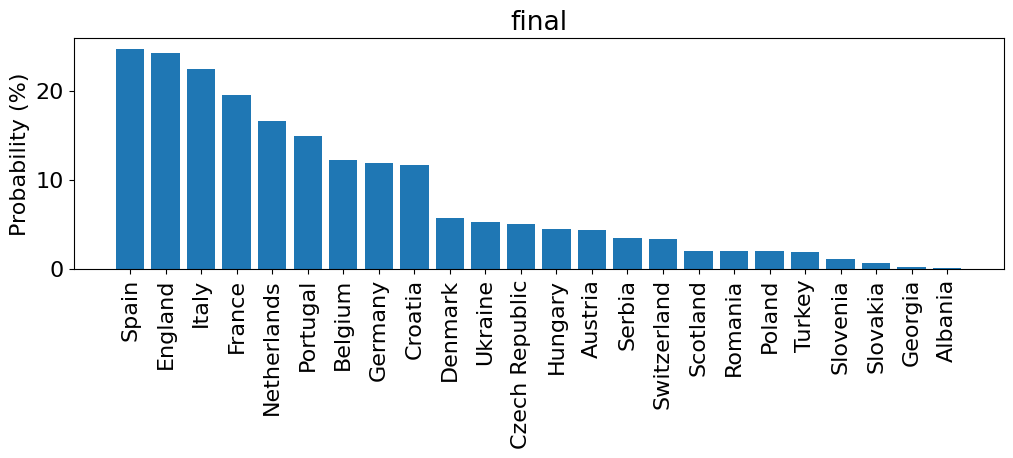

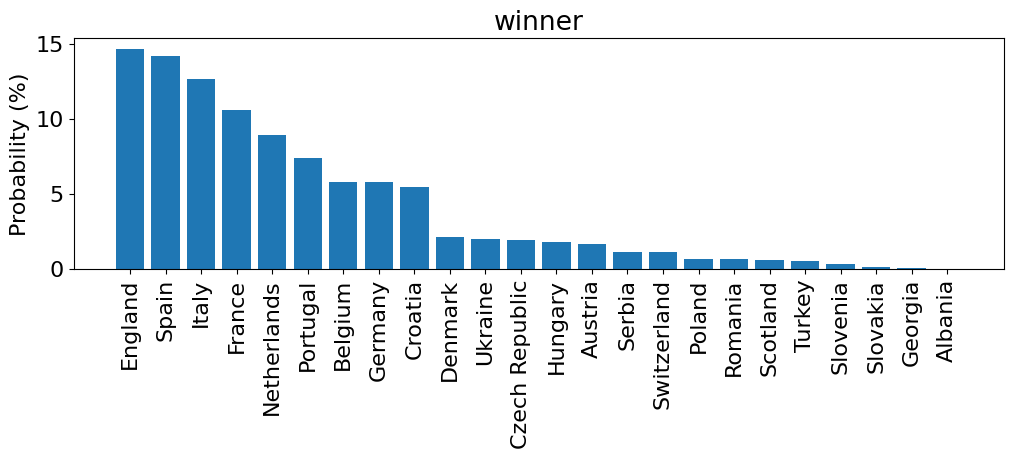

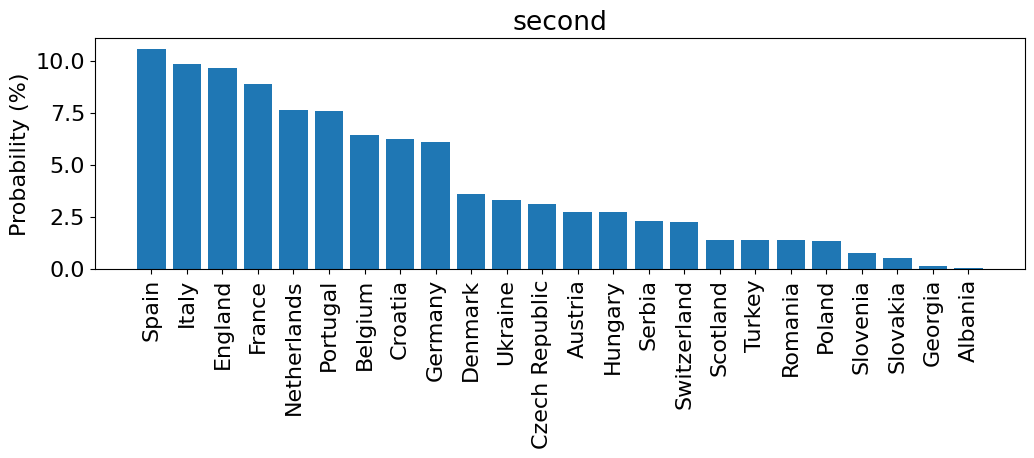

In [27]:
def compute_probas(counts, nr_runs):
    probas = dict()  # category_name --> (team --> proba)
    for cat in categories:
        probas[cat] = dict()
        for team, nr in counts[cat].items():
            probas[cat][team] = nr / nr_runs
    return probas
            
def plot_probas(probas):
    for cat in categories:
        teams_probas = sorted(list(probas[cat].items()), key=lambda t: -t[1])
        # print('------- {} --------'.format(cat))
        # print(list(map(lambda t: (t[0], 100*t[1]), teams_probas)))
        teams_probas_unz = list(zip(*teams_probas))

        plt.figure(figsize=(12, 3))
        plt.bar(range(len(teams_probas)), list(map(lambda v: v*100, teams_probas_unz[1])), tick_label=teams_probas_unz[0])
        plt.xticks(rotation=90)
        plt.ylabel('Probability (%)')
        plt.title(cat)
        
probas = compute_probas(counts, NR_RUNS)
plot_probas(probas)

# Computing How Probabilities Evolved Over Time
Here we'll replay all the `events` as they occured, and see how the probabilities (to end up in each final rounds or to win) evolve for each team.

In [23]:
print(events_to_consider)

NameError: name 'events_to_consider' is not defined

In [14]:
NR_RUNS = 5000
events_that_happened = events[:36]  # those will be anyway factored in (pool matches)
events_to_consider = events[36:]

all_teams = set(kickscores.keys())
probas_over_time = []

for event_idx in range(len(events_to_consider)+1):
    events_so_far = events_that_happened + events_to_consider[:event_idx]
    if len(events_so_far) > 0:
        print('adding: {}...'.format(events_so_far[-1]))
    counts, _ = simulate(events_so_far, NR_RUNS)
    probas = compute_probas(counts, NR_RUNS)
    
    for team in all_teams:
        for category in categories:
            if team not in probas[category]:
                probas[category][team] = 0.
            
    probas_over_time.append(probas.copy())

adding: [PoolMatchResult(team1='Germany', team2='Hungary', result='draw'), ObservedGroupRanking(group='F', ranking=['France', 'Germany', 'Portugal', 'Hungary'])]...


100%|██████████| 5000/5000 [00:00<00:00, 24298.04it/s]


adding: [FinalMatchResult(team1='Wales', team2='Denmark', result='Denmark')]...


100%|██████████| 5000/5000 [00:00<00:00, 29137.67it/s]


adding: [FinalMatchResult(team1='Italy', team2='Austria', result='Italy')]...


100%|██████████| 5000/5000 [00:00<00:00, 29213.78it/s]


adding: [FinalMatchResult(team1='Netherlands', team2='Czech Republic', result='Czech Republic')]...


100%|██████████| 5000/5000 [00:00<00:00, 12288.33it/s]


adding: [FinalMatchResult(team1='Belgium', team2='Portugal', result='Belgium')]...


100%|██████████| 5000/5000 [00:00<00:00, 23703.76it/s]


adding: [FinalMatchResult(team1='Croatia', team2='Spain', result='Spain')]...


100%|██████████| 5000/5000 [00:00<00:00, 28461.01it/s]


adding: [FinalMatchResult(team1='France', team2='Switzerland', result='Switzerland')]...


100%|██████████| 5000/5000 [00:00<00:00, 28358.17it/s]


adding: [FinalMatchResult(team1='England', team2='Germany', result='England')]...


100%|██████████| 5000/5000 [00:00<00:00, 30635.75it/s]


adding: [FinalMatchResult(team1='Sweden', team2='Ukraine', result='Ukraine')]...


100%|██████████| 5000/5000 [00:00<00:00, 29429.95it/s]


adding: [FinalMatchResult(team1='Switzerland', team2='Spain', result='Spain')]...


100%|██████████| 5000/5000 [00:00<00:00, 15335.54it/s]


adding: [FinalMatchResult(team1='Belgium', team2='Italy', result='Italy')]...


100%|██████████| 5000/5000 [00:00<00:00, 32998.94it/s]


adding: [FinalMatchResult(team1='Czech Republic', team2='Denmark', result='Denmark')]...


100%|██████████| 5000/5000 [00:00<00:00, 34814.32it/s]


adding: [FinalMatchResult(team1='Ukraine', team2='England', result='England')]...


100%|██████████| 5000/5000 [00:00<00:00, 35045.64it/s]


adding: [FinalMatchResult(team1='Italy', team2='Spain', result='Italy')]...


100%|██████████| 5000/5000 [00:00<00:00, 34173.55it/s]


adding: [FinalMatchResult(team1='England', team2='Denmark', result='England')]...


100%|██████████| 5000/5000 [00:00<00:00, 35851.57it/s]


In [17]:
probas_over_time[0]['8th']

{'Italy': 1.0,
 'Wales': 1.0,
 'Belgium': 1.0,
 'Denmark': 1.0,
 'Netherlands': 1.0,
 'Austria': 1.0,
 'England': 1.0,
 'Croatia': 1.0,
 'Sweden': 1.0,
 'Spain': 1.0,
 'France': 1.0,
 'Germany': 1.0,
 'Switzerland': 1.0,
 'Ukraine': 1.0,
 'Czech Republic': 1.0,
 'Portugal': 1.0,
 'Scotland': 0.0,
 'Slovakia': 0.0,
 'Finland': 0.0,
 'North Macedonia': 0.0,
 'Hungary': 0.0,
 'Russia': 0.0,
 'Poland': 0.0,
 'Turkey': 0.0}

<ipython-input-61-46162cb4c044>:73: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('/Users/julien/Desktop/probas.pdf', tight_layout=True)


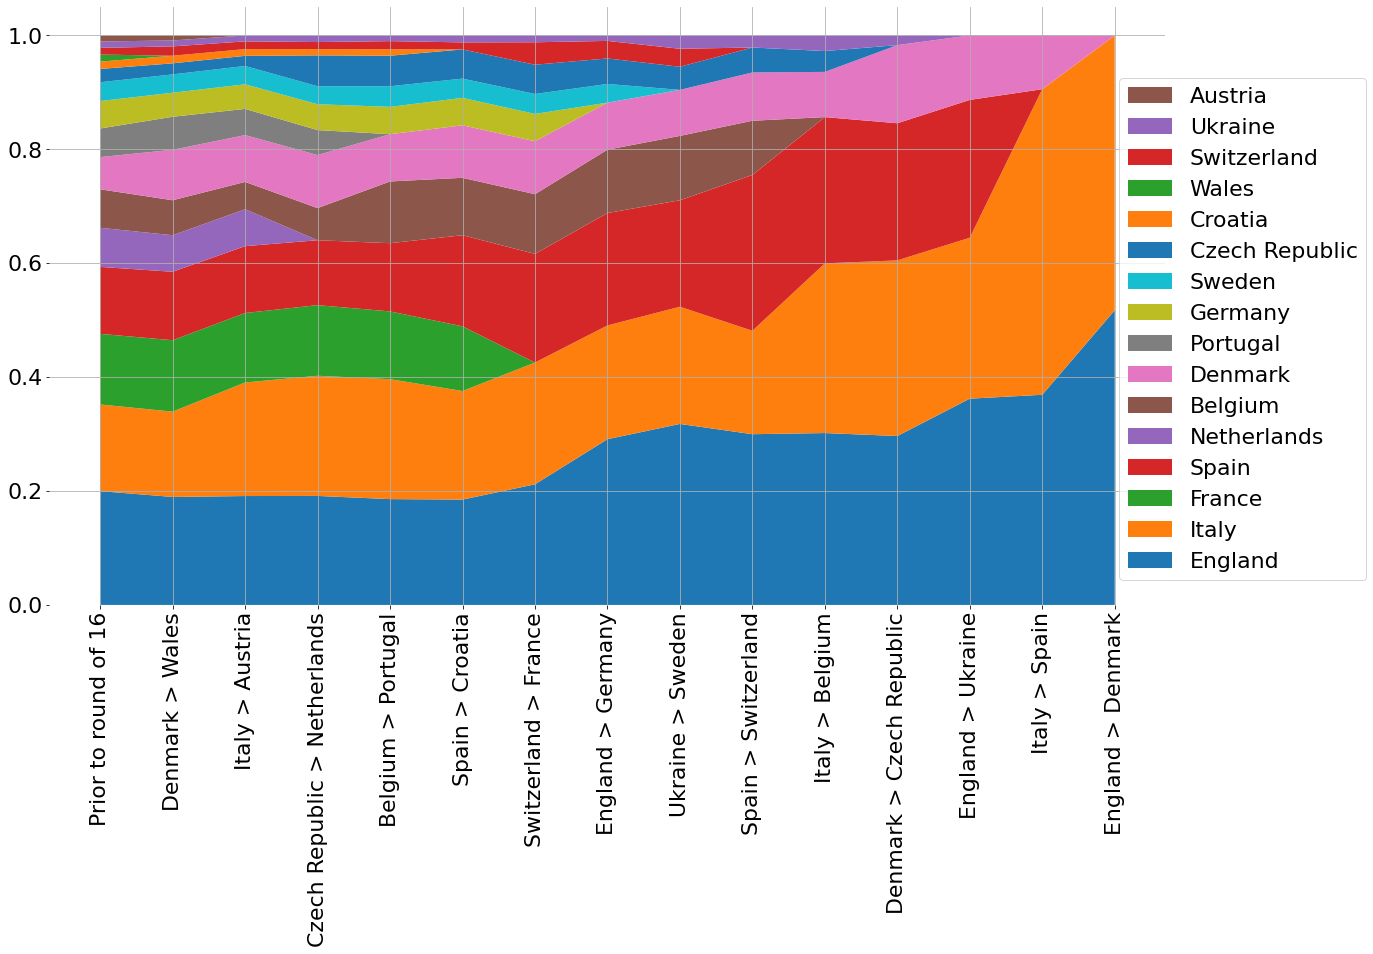

In [61]:
PROBA_TO_PLOT = 'winner'
BAR_PLT = True

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

def create_ticks_from_event(event):
    for ev in event:
        if (isinstance(ev, PoolMatchResult) and ev.result != 'draw') or isinstance(ev, FinalMatchResult):
            winning_team = ev.result
            loosing_team = ev.team1 if ev.team1 != winning_team else ev.team2
            return '{} > {}'.format(winning_team, loosing_team)
        elif isinstance(ev, PoolMatchResult) and ev.result == 'draw':
            return '{} <> {}'.format(ev.team1, ev.team2)

# sorted_teams = list(map(lambda t: t[0], sorted(probas_over_time[0][PROBA_TO_PLOT].items(), key=lambda t: -t[1])))

# plot only teams in 8th of finals
sorted_teams = sorted(map(lambda kv: kv[0], filter(lambda kv: kv[1] > 0., probas_over_time[0]['8th'].items())),
                      key = lambda t: -probas_over_time[0][PROBA_TO_PLOT][t])

# sorted_teams = ['Italy', 'England', 'France', 'Spain', 'Belgium', 'Portugal', 'Germany', 'Switzerland', 'Denmark']

if BAR_PLT:
    plt.figure(figsize=(20,11), frameon=False)

    heights = [
        [probas_over_time[j][PROBA_TO_PLOT][team] for j in range(len(probas_over_time))]
        for team in sorted_teams
    ]
    plt.stackplot(range(len(probas_over_time)), heights, labels=sorted_teams)
            
    plt.xticks(ticks=[-0.] + list(map(lambda t: t+1, range(len(events_to_consider)))), 
           labels=['Prior to round of 16'] + list(map(create_ticks_from_event, events_to_consider)), 
           rotation='vertical')
    
    # get rid of the frame
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
        
    plt.grid()
    plt.legend(reversed(plt.legend().legendHandles), reversed(sorted_teams), bbox_to_anchor=(1.19, 0.9))
        
else:
    # fig = plt.figure(figsize=(13, 20))
    # gs = fig.add_gridspec(nrows=len(sorted_teams), hspace=0.1, wspace=0.05)
    # axs = gs.subplots(sharex=True, sharey=True)
    
    fig, axs = plt.subplots(nrows=len(sorted_teams), figsize=(17, 15), sharey=True, sharex=True)
    
    for i, team in enumerate(sorted_teams):
        probas = [100 * probas_over_time[j][PROBA_TO_PLOT][team] for j in range(len(probas_over_time))]
        axs[i].plot(range(len(probas_over_time)), probas, lw=6)
        axs[i].grid()
        axs[i].plot(range(len(probas_over_time)), [10 for _ in range(len(probas_over_time))], color='k', alpha=0.5)
        
        
        annotation_pos = (0.5, 0.2) if max(probas) > 10. else (0.5, 0.7)
        anno_opts = dict(xy=annotation_pos, xycoords='axes fraction',
                     va='center', ha='center')
        
        axs[i].annotate(team, **anno_opts)
        # axs[i].set_ylabel(team)
    
    plt.xticks(ticks=[0] + list(map(lambda t: t+1, range(len(events_to_consider)))), 
               labels=['Prior to start'] + list(map(create_ticks_from_event, events_to_consider)), 
               rotation='vertical')
    
# plt.tight_layout()
plt.savefig('/Users/julien/Desktop/probas.pdf', tight_layout=True)

# Evaluating bets
In this cell, we "specify" a simple betting system as follows. For each category, we have to predict a number of teams falling in this category `category_to_nr_teams`, as well as the number of points earned for each correct such prediction `category_to_pts`.

Once this is defined, we write a function that takes a "prediction" (i.e., a map from category to set of teams predicted to fall in this category), and returns the distribution of points obtained with this prediction on all the simulation runs.

In [28]:
category_to_nr_teams = {
    '8th': 16,
    '4th': 8,
    'semi': 4,
    'final': 2,
    'winner': 1,
    'second': 1,
}

""" Number of points earned for each team correctly placed in the category
"""
category_to_pts = {
    '8th': 8,
    '4th': 12,
    'semi': 20,
    'final': 30,
    'winner': 60,
    'second': 25,
}

def points_for_preds(predictions):
    """ [predictions] is a map from category name to set of team in this category.
        E.g., 'second' -> set('Belgium')
        
        Returns a list of all scores obtained over each simulation run
    """
    assert(all(len(t[1]) == category_to_nr_teams[t[0]] for t in predictions.items()))  # make sure predictions are valid
    
    all_points = []
    
    for real in realisations:
        pts = 0
        for cat in categories:
            for team_predicted in predictions[cat]:
                pts += category_to_pts[cat] if team_predicted in real[cat] else 0
        all_points.append(pts)

    return all_points

## Expectation-maximizing bet
Here, we compute the expectation-maximizing prediction, and evaluate the number of points we can get with it.

In [29]:
""" Compute the expectation-maximizing prediction
"""

# compute expectation-maximizing predictions
def get_maxe_preds(probas, nr_teams):
    return set(map(lambda t: t[0], sorted(list(probas.items()), key=lambda t: -t[1])[:nr_teams]))

maxe_preds = dict()
for cat in categories:
    maxe_preds[cat] = get_maxe_preds(probas[cat], category_to_nr_teams[cat])

pp = pprint.PrettyPrinter(indent=2)
print('Expectation-maximizing prediction:')
pp.pprint(maxe_preds)

maxe_points = points_for_preds(maxe_preds)
print('Expected number of points with this prediction:', np.mean(maxe_points))

Expectation-maximizing prediction:
{ '4th': { 'Belgium',
           'Croatia',
           'England',
           'France',
           'Italy',
           'Netherlands',
           'Portugal',
           'Spain'},
  '8th': { 'Belgium',
           'Croatia',
           'Czech Republic',
           'Denmark',
           'England',
           'France',
           'Germany',
           'Hungary',
           'Italy',
           'Netherlands',
           'Portugal',
           'Serbia',
           'Spain',
           'Switzerland',
           'Turkey',
           'Ukraine'},
  'final': {'Spain', 'England'},
  'second': {'Spain'},
  'semi': {'France', 'Spain', 'England', 'Italy'},
  'winner': {'England'}}
Expected number of points with this prediction: 217.11188


## Plot the distribution of points obtained by a prediction

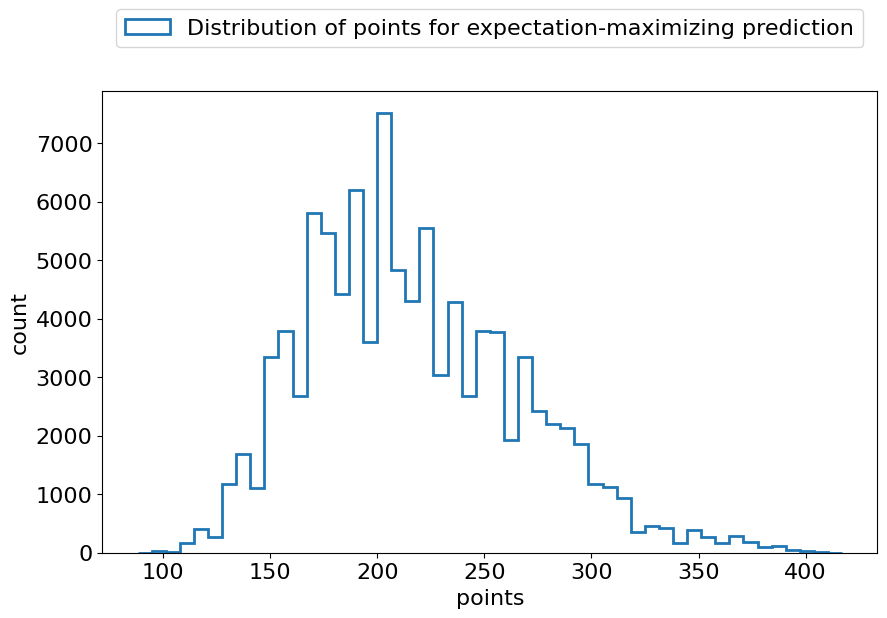

In [30]:
def plot_prediction_points(prediction, label, cumulative=False):
    points = points_for_preds(prediction)
    
    plt.hist(points, bins=100 if cumulative else 50, cumulative=cumulative, histtype='step', lw=2, label=label)
    plt.xlabel('points')
    plt.ylabel('probability to obtain less' if cumulative else 'count')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2))
    
plt.figure(figsize=(10, 6))
plot_prediction_points(maxe_preds, 'Distribution of points for expectation-maximizing prediction')
plt.show()

## Exploration of hand-made predictions
Define my own prediction (at the beginning of tournament), and compare it to the expectation-maximizing one (updated dynamically). Can we for instance find something that limits risk; i.e., is less likely to bring low number of points? Note that the best predictions (in terms of average number of points) need not be consistent with any one realisation (e.g., one team could be the most likely team to be both winner and second).

Expected number of points = 217.11188


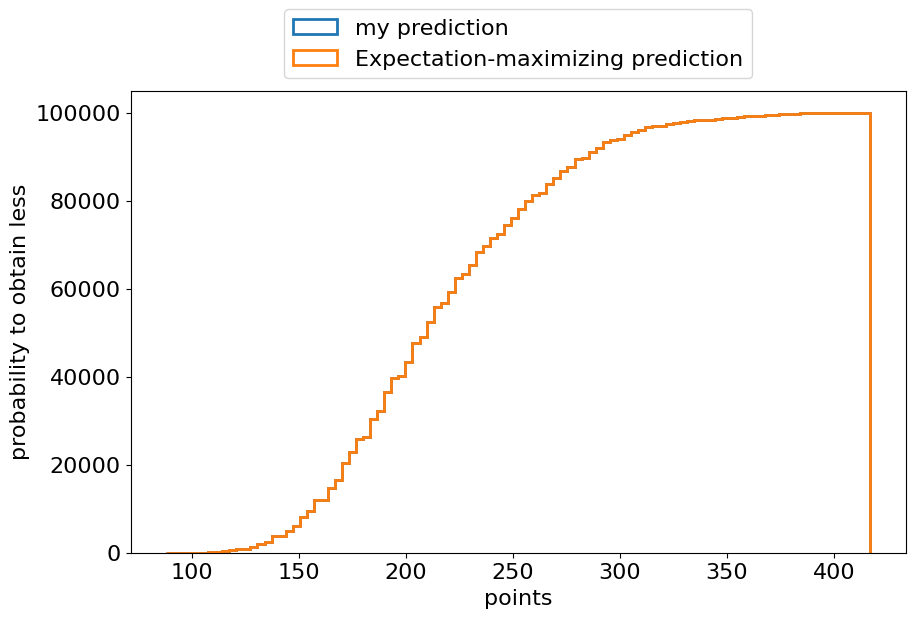

In [33]:
my_pred = { 
  '4th': { 'Belgium',
           'Croatia',
           'England',
           'France',
           'Italy',
           'Netherlands',
           'Portugal',
           'Spain'},
  '8th': { 'Belgium',
           'Croatia',
           'Czech Republic',
           'Denmark',
           'England',
           'France',
           'Germany',
           'Hungary',
           'Italy',
           'Netherlands',
           'Portugal',
           'Serbia',
           'Spain',
           'Switzerland',
           'Turkey',
           'Ukraine'},
  'final': {'Spain', 'England'},
  'second': {'Spain'},
  'semi': {'France', 'Spain', 'England', 'Italy'},
  'winner': {'England'}}

print('Expected number of points =', np.mean(points_for_preds(my_pred)))
plt.figure(figsize=(10, 6))
plot_prediction_points(my_pred, 'my prediction', cumulative=True)
plot_prediction_points(maxe_preds, 'Expectation-maximizing prediction', cumulative=True)
plt.show()

## See a Timeline of How Probabilities Evolved

In [ ]:
counts, realisations = simulate(events, 10000)